<a id='eda_top'>

# EDA and some basic analyses

## EDA  
- [regression](#eda_regress)
- [scatter matrix](#eda_scattermtx)
- [distributions](#eda_dist)
  - [ecdf](#eda_ecdf)
- [dendrogram](#eda_dendro)
- [TSNE](#eda_tsne)

## Basic analyses
The output figures are publishable and are saved to disk.  

- [Analysis of strategical bidding with non-round prices](#eda_digits)  
  Hot plot of occurence of digits in winning prices. 
   
- [Usage intensity](#eda_usage)  
  Above or below average usage (odometer reading) will determine car value. This is a quick analysis of usage intensity. 
  

In [1]:
import drz_config
cfg = drz_config.read_config()
VERBOSE = cfg['VERBOSE']
OPBOD = cfg['OPBOD']
SKIPSAVE = cfg['SKIPSAVE']

if VERBOSE > 0:
    display(cfg)

{'settings_fn': '../code/assets/drz-auction-settings.ini',
 'DATE': '2021-05',
 'VERBOSE': 1,
 'OPBOD': False,
 'URL': 'http://verkoop.domeinenrz.nl/verkoop_bij_inschrijving_2021-0005',
 'EXTEND_URL': False,
 'CLOSEDDATA': True,
 'closed_data_fields': '*',
 'SKIPSAVE': False}

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

In [3]:
# set figure defaults (needs to be in cell seperate from import sns)
plt.style.use(['default', '../assets/movshon.mplstyle', '../assets/context-notebook.mplstyle'])

In [4]:
def diff_month(d1, d2):
    
    '''returns difference in months between two datetime objects'''
    
    return (d1.year - d2.year) * 12 + d1.month - d2.month

def car_name(row):
    
    '''From dataframe row create a sensible name to identify car'''
    
    # index of row
    idx = row.name.strip()
    # fill NaN
    row.fillna({
        'inspection_age':-999.,
        'age':-999.,
    },inplace=True)
    # translate str to datatime object
    # auct = pd.datetime.strptime(idx[0:-5],'%Y-%m')
    auct = pd.to_datetime('-'.join(idx.split('-')[0:2]) + '-01', format='%Y-%m-%d')
    # Manufacture date and year
    mf = auct - pd.to_timedelta(row.age, unit='days')
    mfy = "'" + str(mf.year)[-2:]
    # Inspection date and diff in months
    apk = auct - pd.to_timedelta(row.days_since_inspection_invalid, unit='days')
    apk_month = diff_month(auct,apk)
    
    # construct name    
    name = '{} {:7} {} {} {} {:g}drs {:g}cc {:g}cyl {} {:.1f}km/day '.format(
        mfy,
        row.color,
        row.brand,
        row.model,
        row.body_type,
        row.number_of_doors,
        row.displacement,
        row.number_of_cylinders,
        row.fuel,
        row.odometer/row.age)
    
    # add inspection if any
    if row.days_since_inspection_invalid > 0:
        name += 'inspection invalid'
    else:
        name += 'inspection {:g}m'.format(-apk_month)
        
    return name


In [5]:
if OPBOD:
    fn = '../../../python-nb/data/cars-for-ml-opbod.pkl'
else:
    fn = '../data/cars-for-ml.pkl'

print(f'load {fn}')
df = pd.read_pickle(fn)
if VERBOSE > 1:
    print(df.columns)

# categories
cat_columns = ['brand', 'model', 'fuel', 'body_type','color', 'energy_label', 'fwd']
if VERBOSE > 1:
    print(list(df[cat_columns]))

# sensible name
df['car_name'] = df.apply(car_name,axis='columns')

if VERBOSE > 0:
    display(df.tail(10))
else:
    print('last lot:',df.index[-1])

load ../data/cars-for-ml.pkl


,price,brand,model,age,fuel,odometer,days_since_inspection_invalid,age_at_import,body_type,displacement,...,length,height,width,automatic_gearbox,number_of_gears,energy_label,private_owners,company_owners,under_survey,car_name
2021-05-8147,8639.0,MERCEDES-BENZ,citan,1892.0,diesel,140220.000000,65.0,0.0,stationwagen,1461.0,...,4705.0,1836.0,1829.0,False,6.0,E,0.0,1.0,False,'16 GRIJS MERCEDES-BENZ citan stationwagen 6...
2021-05-8148,NaN,RENAULT,megane,5323.0,benzine,158213.000000,-235.0,0.0,cabriolet,1598.0,...,4355.0,1404.0,1777.0,False,5.0,C,3.0,0.0,False,'06 GRIJS RENAULT megane cabriolet 2drs 1598...
2021-05-8149,3189.0,MERCEDES-BENZ,clk 200 kompressor,5918.0,benzine,224219.000000,142.0,0.0,coupe,1796.0,...,4665.0,1435.0,1740.0,True,5.0,E,3.0,0.0,False,'05 ZWART MERCEDES-BENZ clk 200 kompressor c...
2021-05-8150,4189.0,PEUGEOT,208 5p style 1.,NaN,diesel,43301.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,'24 nan PEUGEOT 208 5p style 1. nan nandrs...
2021-05-8151,677.0,FORD,mondeo zetec b-,2893.0,diesel,297284.461056,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,'13 nan FORD mondeo zetec b- nan nandrs na...
2021-05-8152,13456.0,OPEL,insignia grand sport,1381.0,diesel,49941.000000,-87.0,484.0,hatchback,1956.0,...,4897.0,1455.0,1863.0,False,6.0,E,2.0,1.0,False,'17 WIT OPEL insignia grand sport hatchbac...
2021-05-8154,3255.0,DACIA,duster,2801.0,diesel,121266.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,'13 nan DACIA duster nan nandrs nancc nanc...
2021-05-8155,6064.0,VOLKSWAGEN,passat,3033.0,diesel,197633.000000,362.0,194.0,stationwagen,1968.0,...,4881.0,1536.0,1820.0,True,6.0,F,2.0,1.0,False,'13 ZWART VOLKSWAGEN passat stationwagen 4dr...
2021-05-8157,NaN,HYUNDAI,i30,2403.0,benzine,18048.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,'14 nan HYUNDAI i30 nan nandrs nancc nancy...
2021-05-8158,2222.0,LAND ROVER,range rover sport,5570.0,diesel,294686.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,'06 nan LAND ROVER range rover sport nan n...


<H1><a href="#eda_top">^</a></H1><a id='eda_regress'>

# Price

In [6]:
def get_nr_nc(n):
    nr = int(np.ceil(n**(1/2)))
    nc = int(np.ceil(n/nr))
    return nr,nc

features:
 ['age' 'age_at_import' 'automatic_gearbox' 'company_owners'
 'days_since_inspection_invalid' 'displacement' 'height' 'length'
 'number_of_cylinders' 'number_of_doors' 'number_of_gears'
 'number_of_seats' 'odometer' 'power' 'private_owners' 'registration_tax'
 'sale_price' 'top_speed' 'under_survey' 'weight' 'width']
age
age_at_import
automatic_gearbox
company_owners
days_since_inspection_invalid
displacement
height
length
number_of_cylinders
number_of_doors
number_of_gears
number_of_seats
odometer
power
private_owners
registration_tax
sale_price
top_speed
under_survey
weight
width


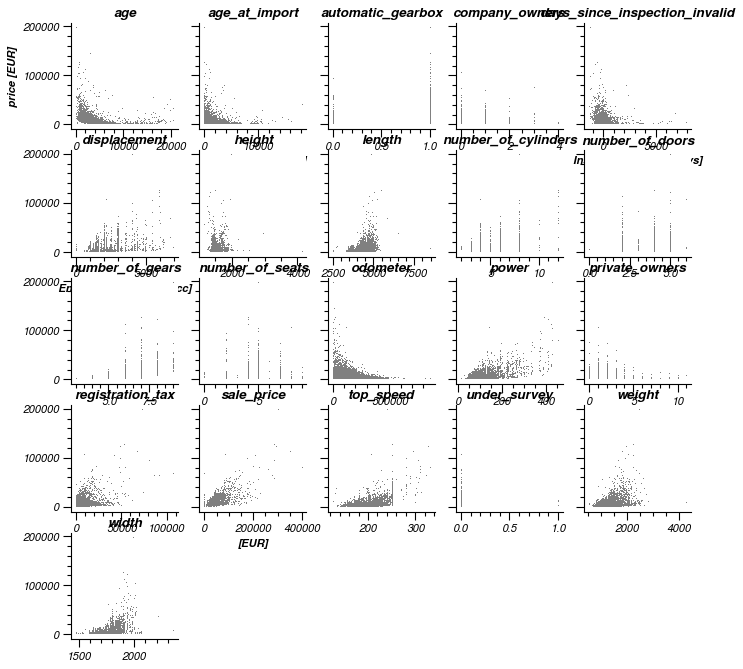

In [7]:
feat = np.setdiff1d(df.columns, cat_columns + ['price', 'car_name'])
X = df.loc[:,feat]
y = df.price
print('features:\n', feat)


if VERBOSE > 0:
    nr,nc = get_nr_nc(len(feat))
    fig,axs = plt.subplots(nrows=nr, ncols=nc, figsize=[2*nc,2*nr], sharey=True)

    for iF,ax in enumerate(axs.ravel()):
        if iF >= len(feat):
            ax.set_visible(False)
            continue

        print(feat[iF])
        ax.plot(X.iloc[:,iF],y,',k')
        ax.set_title(feat[iF])
        if feat[iF] == 'displacement':
            ax.set_xlabel('Engine displacement [cc]')
        elif feat[iF] == 'age':
            ax.set_xlabel('Age [days]')
        elif feat[iF] == 'age_at_import':
            ax.set_xlabel('Age at import [days]')
        elif feat[iF] == 'days_since_inspection_invalid':
            ax.set_xlabel('Inspection invalid [days]')
        elif feat[iF] == 'power':
            #nettomaximumvermogen
            ax.set_xlabel('[kW]')
        elif feat[iF] == 'odometer':
            ax.set_xlabel('[km]')
        elif feat[iF] == 'registration_tax':
            ax.set_xlabel('[EUR]')
        elif feat[iF] == 'sale_price':
            ax.set_xlabel('[EUR]')

    
    
    axs.ravel()[0].set_ylabel('price [EUR]')


<H1><a href="#eda_top">^</a></H1><a id='eda_scattermtx'>

In [8]:
yX = pd.concat([y, X], axis='columns').fillna(np.NaN)

# group per car brand
yX['brand'] = df.brand
grouped = yX.groupby('brand')
VW = grouped.get_group('VOLKSWAGEN')
RENAULT = grouped.get_group('RENAULT')
MERC = grouped.get_group('MERCEDES-BENZ')
FORD = grouped.get_group('FORD')
OPEL = grouped.get_group('OPEL')
SMART = grouped.get_group('SMART')

is_diesel = df.fuel == 'diesel' # Future use


In [9]:
if VERBOSE > 1:
    df_ = MERC
    brand = df_.brand.values[0]
    num_cols = [c for c in df_.columns if df_[c].dtype != 'object']
    pd.plotting.scatter_matrix(df_[num_cols].astype(float), grid=True, figsize=[16,16], diagonal='kde')
    plt.suptitle(f'{brand} n={df_.shape[0]:.0f}\nAll numerical features')

<H1><a href="#eda_top">^</a></H1><a id='eda_dist'>

# Distributions

In [10]:
def ecdf(data):
    d = data[data.notna()]
    y = np.linspace(0,1,len(d))
    x = sorted(d)
    return x,y

## Simple bar graphs

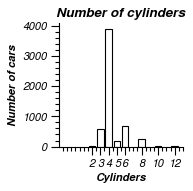

/home/tom/bin/py38-satdatsci/lib/python3.8/site-packages/matplotlib/ticker.py:2957: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/tom/bin/py38-satdatsci/lib/python3.8/site-packages/matplotlib/ticker.py:2957: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


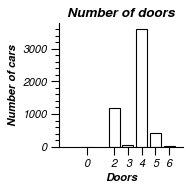

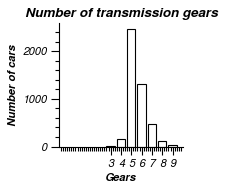

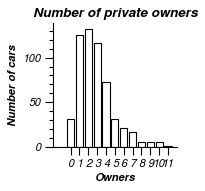

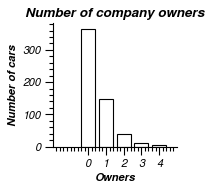

In [11]:
if VERBOSE > 0:
    # loop over fields
    for data, title_label, xaxis_label in zip(
        [
            yX.number_of_cylinders,
            yX.number_of_doors,
            yX.number_of_gears,
            yX.private_owners,
            yX.company_owners,
        ],
        [
            'Number of cylinders',
            'Number of doors',
            'Number of transmission gears',
            'Number of private owners',
            'Number of company owners',
        ],
        [
            'Cylinders',
            'Doors',
            'Gears',
            'Owners',
            'Owners',
        ]
    ):
        # "histogram"
        cnt = data.value_counts()
        # create figure
        plt.figure(figsize=[2,2])
        # plot bars
        plt.bar(x=cnt.index, height=cnt.values, edgecolor='k', facecolor='None')
        # prettify
        ax = plt.gca()
        ax.set_title(title_label, style='italic')
        ax.set_xlabel(xaxis_label, style='italic')
        ax.set_ylabel('Number of cars', style='italic')
        ax.set_xlim(left=-2, right=cnt.index.max()+1)
        ax.set_xticks(cnt.index)


<H1><a href="#eda_top">^</a></H1><a id='eda_ecdf'>

## Ecdf of Length, Width, Height, Weight, Speed, Power etc.

Red is with imputed median

Length
	min: 2500.0
	mid: 4349.0
	max: 8450.0
	bin: 2000 : 200.0 : 9000 (n=35)
Width
	min: 1475.0
	mid: 1765.0
	max: 2350.0
	bin: 1000 : 25.0 : 2500 (n=60)
Height
	min: 1165.0
	mid: 1481.0
	max: 4128.0
	bin: 1000 : 50.0 : 5000 (n=80)
Weight
	min: 550.0
	mid: 1285.0
	max: 4280.0
	bin: 500 : 100.0 : 5000 (n=45)
Top speed
	min: 125.0
	mid: 192.0
	max: 331.0
	bin: 100 : 5.0 : 350 (n=50)
Power
	min: 13.0
	mid: 88.0
	max: 456.0
	bin: 0 : 10.0 : 500 (n=50)
Sale price
	min: 0.0
	mid: 30848.0
	max: 398150.0
	bin: 0 : 10000.0 : 500000 (n=50)
Engine displacement
	min: 0.0
	mid: 1781.0
	max: 6965.0
	bin: 0 : 100.0 : 10000 (n=100)


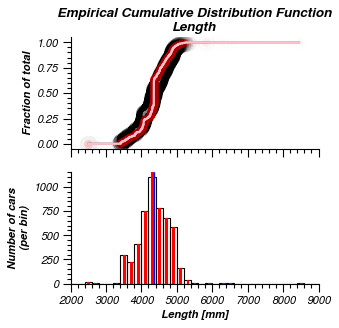

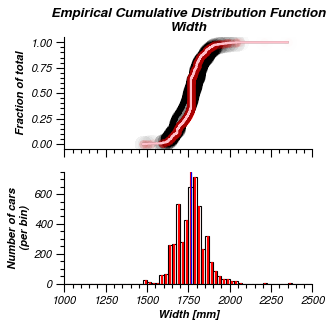

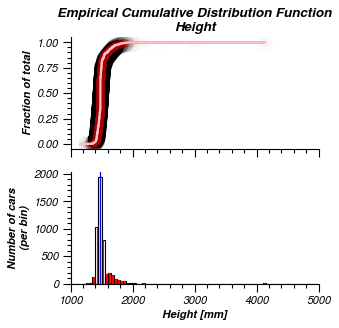

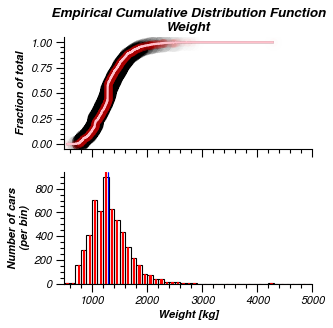

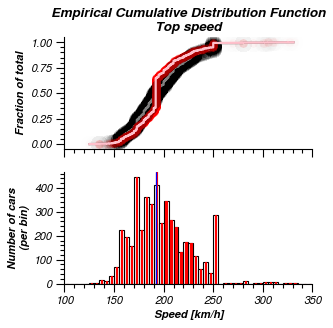

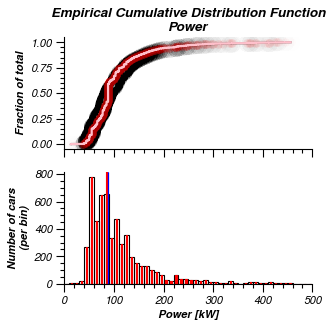

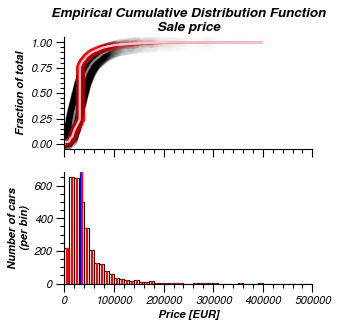

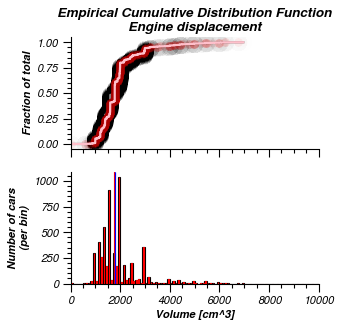

In [12]:
if VERBOSE > 0:
    # loop over fields
    for data, title_label, xaxis_label, bins in zip(
        # data
        [
            yX.length, 
            yX.width,
            yX.height,
            yX.weight,
            yX.top_speed,
            yX.power,
            yX.sale_price,
            yX.displacement,
        ],
        # title
        [
            'Length', 
            'Width',
            'Height',
            'Weight',
            'Top speed',
            'Power',
            'Sale price',
            'Engine displacement'
        ],
        # xlabel
        [
            'Length [mm]', 
            'Width [mm]',
            'Height [mm]',
            'Weight [kg]',
            'Speed [km/h]',
            'Power [kW]',
            'Price [EUR]',
            'Volume [cm^3]'
        ],
        # bins: left, right, nr of steps
        [
            (2000, 9000, 36), 
            (1000, 2500, 61),
            (1000, 5000, 81),
            (500, 5000, 46),
            (100, 350, 51), 
            (0, 500, 51), 
            (0, 500000, 51), 
            (0, 10000, 101)
        ],
    ):
        # separate tuple in 3 different values
        left_bin_edge, right_bin_edge, bin_steps = bins

        # prepare x and y from values
        x,y = ecdf(data)
        # store median value
        median_value = data.median()
        # reporting
        print('{}\n\tmin: {}\n\tmid: {}\n\tmax: {}\n\tbin: {} : {} : {} (n={})'.format(
            title_label, 
            x[0], median_value, x[-1], 
            left_bin_edge, (right_bin_edge-left_bin_edge)/(bin_steps-1), right_bin_edge, bin_steps-1
        ))
        # warn if out of bounds
        if (x[0] < left_bin_edge) or (x[-1] > right_bin_edge):
            print('>> CLIPPING <<\n')

        # plot full
        fig,axs=plt.subplots(figsize=[4,4], nrows=2, ncols=1, sharex=True)

        axs[0].step(x, y, markerfacecolor='k', markeredgecolor='none', marker='o', alpha=0.005, ms=16)
        axs[0].step(x, y, color='grey', linestyle='-', linewidth=2)

        axs[1].hist(x, bins=np.linspace(left_bin_edge, right_bin_edge, bin_steps), edgecolor='k', facecolor='None')
        yl=axs[1].get_ylim()
        axs[1].vlines(x=median_value, ymin=0, ymax=yl[1], color='b')
        axs[1].set_ylim(bottom=yl[0], top=yl[1])


        # prepare data with median replacing NaNs
        data = data.fillna(median_value)
        x,y = ecdf(data)

        # plot nan replaced
        axs[0].step(x, y, markerfacecolor='r', markeredgecolor='none', marker='o', alpha=0.01, ms=8)
        axs[0].step(x, y, color='pink', linestyle='-', linewidth=2)

        axs[1].hist(x, bins=np.linspace(left_bin_edge, right_bin_edge, bin_steps), edgecolor='r', facecolor='r', rwidth = 0.25)
        yl=axs[1].get_ylim()
        axs[1].vlines(x=median_value, ymin=0, ymax=yl[1], color='b')
        axs[1].set_ylim(bottom=yl[0], top=yl[1])

        # prettify
        axs[0].set_xlim(left=left_bin_edge, right=right_bin_edge)
        axs[0].set_title('Empirical Cumulative Distribution Function\n' + title_label, style='italic')
        axs[0].set_yticks(np.linspace(0,1.0,5))
        axs[1].set_xlabel(xaxis_label, style='italic')
        axs[0].set_ylabel('Fraction of total', style='italic')
        axs[1].set_ylabel('Number of cars\n(per bin)', style='italic')


## Age at import
zoom into two clusters of data

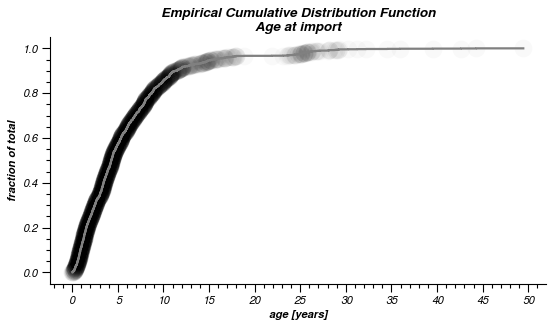

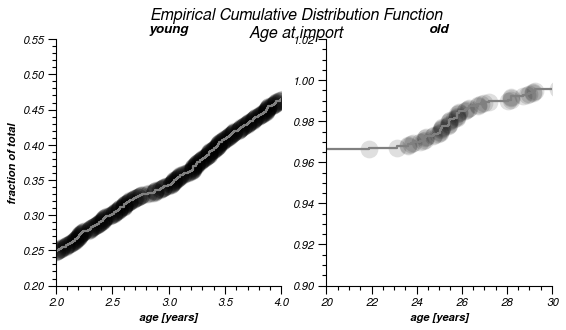

In [13]:
data = yX.age_at_import[yX.age_at_import>0]/365.25
x,y = ecdf(data)

if VERBOSE > 0:
    # plot full
    plt.figure(figsize=[8,4])
    plt.step(x, y, markerfacecolor='k', markeredgecolor='none', marker='o', alpha=0.025, ms=16)
    plt.step(x, y, color='grey', linestyle='-', linewidth=2)
    plt.title('Empirical Cumulative Distribution Function\nAge at import')
    plt.xlabel('age [years]')
    plt.ylabel('fraction of total')
    plt.xticks(range(0,55,5))


    # plot old/young
    fig,axs = plt.subplots(figsize=[8,4], ncols=2, nrows=1)
    axs[0].step(x, y, markerfacecolor='k', markeredgecolor='none', marker='o', alpha=0.125, ms=16)
    axs[0].step(x, y, color='grey', linestyle='-', linewidth=2)
    axs[1].step(x, y, markerfacecolor='k', markeredgecolor='none', marker='o', alpha=0.125, ms=16)
    axs[1].step(x, y, color='grey', linestyle='-', linewidth=2)
    fig.suptitle('Empirical Cumulative Distribution Function\nAge at import')
    axs[0].set_xlim(left=2, right=4)
    axs[1].set_xlim(left=20, right=30)
    axs[0].set_ylim(bottom=0.2, top=0.55)
    axs[1].set_ylim(bottom=0.9, top=1.02)
    axs[0].set_ylabel('fraction of total')
    axs[0].set_xlabel('age [years]')
    axs[1].set_xlabel('age [years]')
    axs[0].set_title('young')
    axs[1].set_title('old')


## Price
on log scale

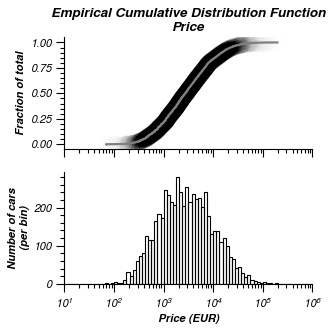

In [14]:
data = df.price
x,y = ecdf(data)

if VERBOSE > 0:
    
    # plot full
    fig,axs=plt.subplots(figsize=[4,4], nrows=2, ncols=1, sharex=True)

    axs[0].step(x, y, markerfacecolor='k', markeredgecolor='none', marker='o', alpha=0.005, ms=16)
    axs[0].step(x, y, color='grey', linestyle='-', linewidth=2)
    # axs[0].plot(median_usage, 0.5, marker='+', color='b', ms=64)
    # axs[0].text(median_usage,0.5,'Median: {:.1f} km/day      '.format(median_usage), ha='right', va='center', color='b', weight='bold')

    axs[1].hist(x, bins=np.logspace(1,6,81), edgecolor='k', facecolor='None')
    yl=axs[1].get_ylim()
    # axs[1].vlines(x=median_usage, ymin=0, ymax=yl[1], color='b')

    axs[0].set_xscale('log')
    axs[0].set_xlim(left=10, right=1000000)
    axs[0].set_title('Empirical Cumulative Distribution Function\nPrice', style='italic')
    axs[0].set_yticks(np.linspace(0,1.0,5))
    axs[1].set_xlabel('Price (EUR)', style='italic')
    axs[0].set_ylabel('Fraction of total', style='italic')
    axs[1].set_ylabel('Number of cars\n(per bin)', style='italic')


<H1><a href="#eda_top">^</a></H1><a id='eda_dendro'>

- - - - 
# Dendrogram

This is a form of classification and produce a tree-like visualization


cluster 1

	'16 ZWART   OPEL corsa-e hatchback 5drs 1248cc 4cyl diesel 52.8km/day inspection 3m
	'09 GEEL    OPEL corsa hatchback 4drs 1364cc 4cyl benzine 21.6km/day inspection 5m
	'11 GRIJS   OPEL corsa mpv 4drs 1229cc 4cyl benzine 27.0km/day inspection invalid
	'10 GRIJS   OPEL astra mpv 4drs 1598cc 4cyl benzine 25.3km/day inspection 3m
	'16 ZWART   OPEL corsa-e hatchback 5drs 1248cc 4cyl diesel 50.3km/day inspection 0m
	'12 WIT     OPEL agila stationwagen 4drs 996cc 3cyl benzine 21.7km/day inspection 2m
	'17 WIT     OPEL insignia grand sport hatchback 5drs 1956cc 4cyl diesel 36.2km/day inspection 2m

cluster 2

	'06 ZWART   OPEL zafira mpv 4drs 2198cc 4cyl benzine 48.7km/day inspection invalid
	'12 ZWART   OPEL corsa mpv 4drs 1248cc 4cyl diesel 73.1km/day inspection 1m
	'05 ZWART   OPEL astra gtc coupe 2drs 1598cc 4cyl benzine 46.9km/day inspection 1m
	'04 GRIJS   OPEL astra hatchback 4drs 1796cc 4cyl benzine 40.2km/day inspection 5m
	'13 BRUIN   OPEL corsa mpv 4drs 1248cc 4cyl die

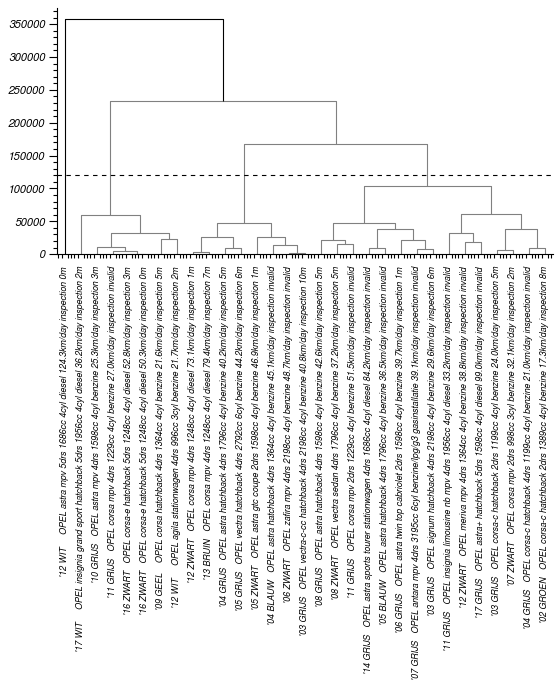

In [15]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

np.random.seed(42)

train = OPEL.drop(columns='brand').dropna()
if train.shape[0] < 10:
    train = OPEL.drop(columns=['brand', 'under_survey', 'private_owners', 'company_owners']).dropna()

mergings = linkage(train,method='complete')
brand_names = df.loc[train.index,'brand']
model_names = df.loc[train.index,'model']
color_names = df.loc[train.index,'color']
fuel_names = df.loc[train.index,'fuel']
lot_names = df.loc[train.index,:].index
names = df.loc[train.index,"car_name"]
# names = brand_names

level = 120000 # arbitrary!
labels = fcluster(mergings,level,criterion='distance')

if VERBOSE > 0:
    plt.figure(figsize=[8,4])
    dendrogram(mergings,
               labels=names,
               leaf_rotation=90,
               leaf_font_size=8,
              );
    plt.plot([0,train.shape[0]*10],[level,level],'--')

for l in range(1,labels.max()+1):
    print('\ncluster {}\n'.format(l))
    idx = train[labels == l].index
    for i in idx:
        print('\t{}'.format(df.loc[i,"car_name"]))
    

<H1><a href="#eda_top">^</a></H1><a id='eda_tsne'>

# tSNE

see if there are clusters

#### Train

In [16]:
from sklearn.manifold import TSNE

# remove categories
train = df.drop(columns=['brand','model','fuel','body_type','color','car_name', 'energy_label', 'fwd']).dropna()
if train.shape[0] < 100:
    train = df.drop(columns=['brand','model','fuel','body_type','color','car_name', 'energy_label', 'fwd', 'under_survey', 'private_owners', 'company_owners']).dropna()

display(train.info())
display(train.describe())

model = TSNE(learning_rate = 100,verbose=1)
transformed = model.fit_transform(train)


<class 'pandas.core.frame.DataFrame'>
Index: 344 entries, 2021-01-2201 to 2021-05-8155
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   price                          344 non-null    float64
 1   age                            344 non-null    float64
 2   odometer                       344 non-null    float64
 3   days_since_inspection_invalid  344 non-null    float64
 4   age_at_import                  344 non-null    float64
 5   displacement                   344 non-null    float64
 6   number_of_cylinders            344 non-null    float64
 7   power                          344 non-null    float64
 8   weight                         344 non-null    float64
 9   registration_tax               344 non-null    float64
 10  sale_price                     344 non-null    float64
 11  number_of_seats                344 non-null    float64
 12  number_of_doors                344 

None

,price,age,odometer,days_since_inspection_invalid,age_at_import,displacement,number_of_cylinders,power,weight,registration_tax,sale_price,number_of_seats,number_of_doors,top_speed,length,height,width,number_of_gears,private_owners,company_owners
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.00000,344.000000
mean,8720.976744,3593.520349,181281.360465,-11.046512,608.561047,1887.642442,4.279070,113.241570,1327.642442,6379.087209,35410.188953,4.965116,3.921512,203.404070,4386.979651,1506.049419,1780.098837,5.915698,2.75000,0.505814
std,11774.110020,1748.403468,95965.017076,333.054138,1043.083868,745.559404,1.113408,63.738921,300.465048,6558.951294,38851.201005,0.605084,0.936591,29.581179,388.918591,95.640699,77.641334,0.987613,2.00909,0.763581
min,270.000000,195.000000,975.000000,-1266.000000,0.000000,898.000000,3.000000,43.000000,715.000000,0.000000,0.000000,2.000000,2.000000,150.000000,3410.000000,1259.000000,1475.000000,4.000000,0.00000,0.000000
25%,1887.500000,2223.750000,111242.000000,-171.500000,0.000000,1399.000000,4.000000,73.750000,1119.750000,1881.250000,10331.000000,5.000000,4.000000,181.000000,4116.250000,1456.500000,1735.000000,5.000000,1.00000,0.000000
50%,4500.000000,3350.000000,175924.500000,-24.500000,0.000000,1598.000000,4.000000,92.000000,1293.500000,4586.500000,28030.000000,5.000000,4.000000,200.000000,4362.000000,1481.000000,1787.500000,6.000000,2.00000,0.000000
75%,10874.500000,4962.250000,236286.750000,116.250000,845.000000,1995.000000,4.000000,132.500000,1480.000000,8862.000000,46581.750000,5.000000,4.000000,225.000000,4672.750000,1513.000000,1820.000000,6.000000,4.00000,1.000000
max,105000.000000,7930.000000,534136.000000,2059.000000,5516.000000,5786.000000,12.000000,426.000000,2364.000000,47837.000000,260858.000000,8.000000,6.000000,310.000000,5293.000000,1953.000000,2019.000000,9.000000,11.00000,4.000000


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 344 samples in 0.000s...
[t-SNE] Computed neighbors for 344 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 344 / 344
[t-SNE] Mean sigma: 4540.391613
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.204121
[t-SNE] KL divergence after 1000 iterations: 0.309078


#### plot

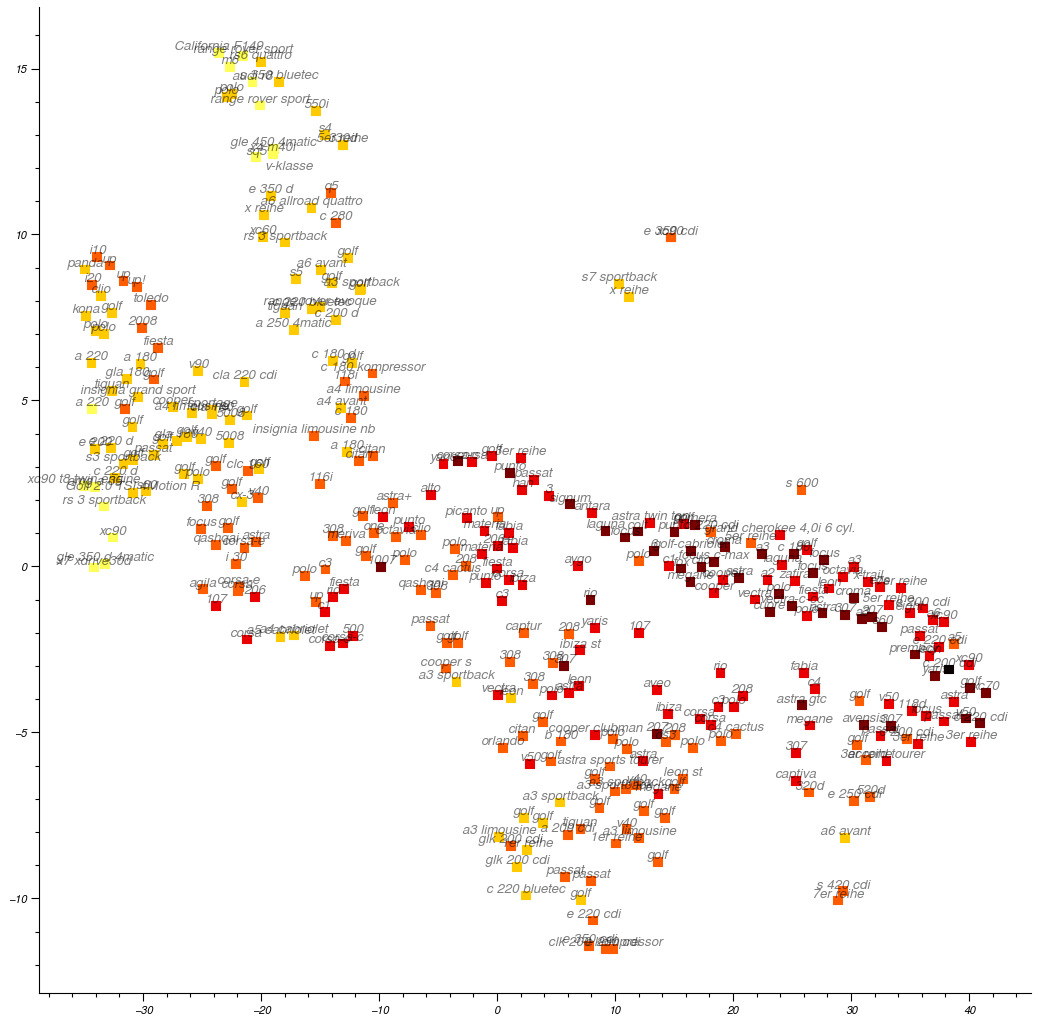

In [17]:
if VERBOSE > 0:

    # Labeling

    # year
    year_bins = np.arange(
        df.loc[train.index,"age"].min(),
        df.loc[train.index,"age"].max(),365)
    year_labels = [i for i in range(len(year_bins)-1)]

    # price
    price_bins = np.logspace(1, 6, 11)
    price_labels = [i for i in range(len(price_bins)-1)]

    # color, fuel, brand
    labels = df.loc[train.index,'color']
    labels = df.loc[train.index,'fuel']
    labels = df.loc[train.index,'brand']
    labels = pd.factorize(labels)[0]

    labels = pd.cut(train.age,bins=year_bins,labels=year_labels)
    labels = pd.cut(train.price,bins=price_bins,labels=price_labels)

    # name labels
    names = df.loc[train.index,'model']
    # names = train.index

    # plot
    xs = transformed[:,0]
    ys = transformed[:,1]
    plt.figure(figsize=[16,16])
    plt.set_cmap('hot')
    plt.scatter(xs,ys,c=labels,marker='s')
    cm=plt.get_cmap()
    # text labels
    for x,y,t,l in zip(xs,ys,names,labels):
        c = cm(l/max(labels))
        plt.text(x,y,t,color='k',ha='center',va='bottom', alpha=0.5)


- - - - 
# Results

The results here below surpass eda and are beter made suitable for publication
- - - - 

<H1><a href="#eda_top">^</a></H1><a id='eda_digits'>

# Last digits of price

In [18]:
# 2d hist
last0_digit = df.price.dropna().astype(str).apply(lambda x:x[-3]).astype(int)
last1_digit = df.price.dropna().astype(str).apply(lambda x:x[-4]).astype(int)
cnt,b0,b1 = np.histogram2d(last1_digit, last0_digit, bins=[10,10],range=[(-0.5,9.5),(-0.5,9.5)])
_xx, _yy = np.meshgrid(b0[1:]-.5, b1[1:]-.5)
x, y = _xx.ravel(), _yy.ravel()

# normalize to expected value if homogenous
norm_cnt = np.log10(cnt/(cnt.ravel().sum()/100))

# sort reversed
idx = cnt.ravel().argsort()[::-1]

digits = pd.DataFrame(data={
    'occurrence':cnt.ravel().astype(int),
    'normalized':norm_cnt.ravel()[idx],
    'last-1':y.astype(int),
    'last-0':x.astype(int),
    'last 2 digits':['{:02.0f}'.format(f) for f in (y*10 + x)]
}).set_index('last 2 digits')
digits.sort_values(by='occurrence', ascending=False, inplace=True)

if VERBOSE > 1:
    display(digits)

digits_max = digits.iloc[0,[c in ['last-1','last-0'] for c in digits.columns]]
digits_min = digits.iloc[-1,[c in ['last-1','last-0'] for c in digits.columns]]

,occurrence,normalized,last-1,last-0
last 2 digits,,,,
00,533,0.973834,0,0
50,248,-0.150833,5,0
55,214,-0.184691,5,5
11,185,0.224830,1,1
89,159,-0.711500,8,9
...,...,...,...,...
72,7,-0.430674,7,2
84,7,-0.522444,8,4
37,7,0.010535,3,7


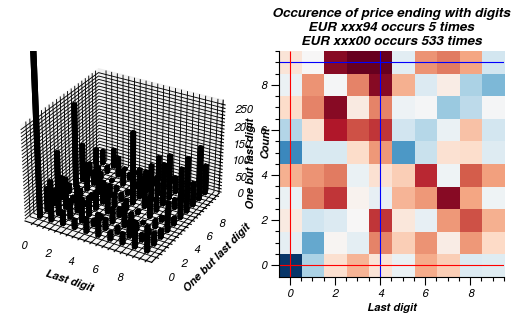

In [19]:
if VERBOSE > 0:
    display(digits)
    # plot
    from mpl_toolkits.mplot3d import Axes3D

    width = depth = .25
    bottom = np.zeros_like(cnt.ravel())

    fig = plt.figure(figsize=(8, 4))

    ax1 = fig.add_subplot(121, projection='3d')
    ax1.bar3d(x,y,bottom,width,depth,cnt.ravel())

    ax2 = fig.add_subplot(122)
    ax2.imshow(norm_cnt,vmax=+1,vmin=-1,
               cmap='RdBu',
               origin='lower')

    plt.hlines(digits_min[0],-0.5,9.5,color='b')
    plt.vlines(digits_min[1],-0.5,9.5,color='b')
    plt.hlines(digits_max[0],-0.5,9.5,color='r')
    plt.vlines(digits_max[1],-0.5,9.5,color='r')

    ax1.set_xlabel('Last digit')
    ax2.set_xlabel('Last digit')
    ax1.set_ylabel('One but last digit')
    ax2.set_ylabel('One but last digit')
    ax1.set_zlabel('Count')
    ax1.set_zlim(top=cnt.max()/2)
    ax2.set_title('Occurence of price ending with digits\nEUR xxx{:1.0f}{:1.0f} occurs {:.0f} times\nEUR xxx{:1.0f}{:1.0f} occurs {:.0f} times'.format(*digits_min,digits.iloc[-1].occurrence,
                                                                                                      *digits_max,digits.iloc[0].occurrence));


../results/last-two-digits.png


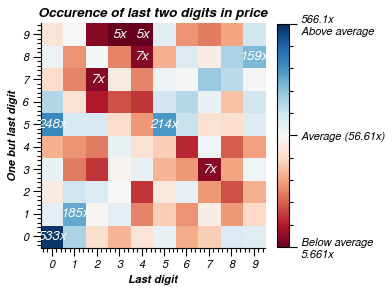

In [20]:
# plot for publication
fig,ax = plt.subplots(figsize=(4, 4))
imgplot = ax.imshow(norm_cnt,vmax=1,vmin=-1,
           cmap='RdBu',
           origin='lower')

# least and most occuring pairs
for i,d in digits.iloc[0:5,:].iterrows():
    x=d['last-0']
    y=d['last-1']
    label = '{:g}x'.format(d.occurrence)
    ax.text(x,y,label,
            color='w',
            ha='center',va='center',
            bbox={'alpha':0,'color':'k'})
for i,d in digits.iloc[-5:,:].iterrows():
    x=d['last-0']
    y=d['last-1']
    label = '{:g}x'.format(d.occurrence)
    ax.text(x,y,label, 
            color='w',
            ha='center',va='center',
            bbox={'alpha':0,'color':'k'})
    
# labels
ax.set_xticks(range(0,10))
ax.set_yticks(range(0,10))
ax.set_title('Occurence of last two digits in price', style='italic')
ax.set_xlabel('Last digit', style='italic')
ax.set_ylabel('One but last digit', style='italic')

# colorbar
cbar = fig.colorbar(imgplot, ticks=[-1,0,+1], fraction=.045, aspect=20)
cbar.ax.set_yticklabels([
    'Below average\n{:.3f}x'.format(cnt.ravel().sum()/1000), 
    'Average ({:.2f}x)'.format(cnt.ravel().sum()/100), 
    '{:.1f}x\nAbove average'.format(cnt.ravel().sum()/10), 
])

# save
if OPBOD:
    file_name = '../results/last-two-digits-opbod.png'
else:
    file_name = '../results/last-two-digits.png'

if (SKIPSAVE==False): #and (not(os.path.isfile(file_name))):
    print(file_name)
    with plt.style.context('../assets/context-paper.mplstyle'):
        plt.savefig(file_name, bbox_inches='tight', transparent=True)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')

<H1><a href="#eda_top">^</a></H1><a id='eda_usage'>

# Usage intensity

## Odometer
Distance travelled

median odo meter: 187.119
../results/odometer-ecdf.png


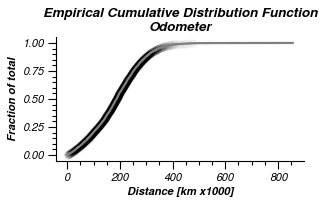

In [21]:
data = yX.odometer/1000
x,y = ecdf(data)

# plot full
plt.figure(figsize=[4,2])
plt.step(x, y, markerfacecolor='k', markeredgecolor='none', marker='o', alpha=1/256, ms=8)
plt.step(x, y, color='grey', linestyle='-', linewidth=2)
plt.title('Empirical Cumulative Distribution Function\nOdometer', style='italic')
plt.xlabel('Distance [km x1000]', style='italic')
plt.ylabel('Fraction of total', style='italic')

plt.yticks(np.linspace(0,1.0,5))

print('median odo meter:', np.median(x))

# save
if OPBOD:
    file_name = '../results/odometer-ecdf-opbod.png'
else:
    file_name = '../results/odometer-ecdf.png'

if (SKIPSAVE==False): #and (not(os.path.isfile(file_name))):
    print(file_name)
    with plt.style.context('../assets/context-paper.mplstyle'):
        plt.savefig(file_name, bbox_inches='tight', transparent=True)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')

## Car age

../results/age-ecdf.png


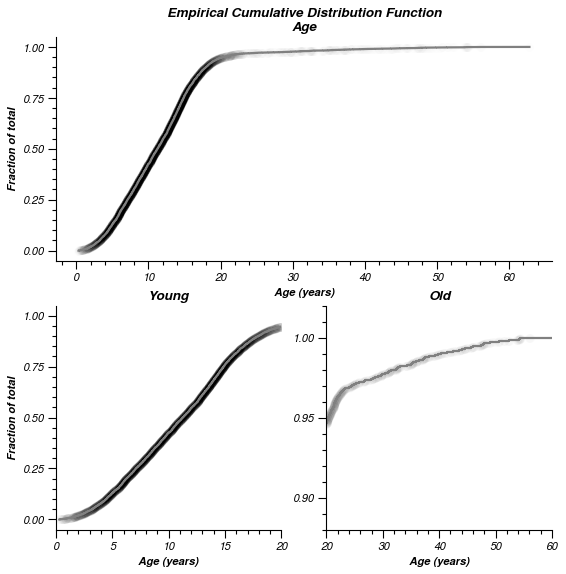

In [22]:
data = yX.age[yX.age>0]/365.25
x,y = ecdf(data)


fig,axs = plt.subplots(figsize=[8,8], ncols=2, nrows=2)
# plot full
plt.subplot(211)
plt.step(x, y, markerfacecolor='k', markeredgecolor='none', marker='o', alpha=1/128, ms=8)
plt.step(x, y, color='grey', linestyle='-', linewidth=2)
plt.xlabel('Age (years)', style='italic')
plt.ylabel('Fraction of total', style='italic')
plt.title('Empirical Cumulative Distribution Function\nAge', style='italic')
plt.yticks(np.linspace(0,1.0,5))
# plt.gca().tick_params(labelsize=24)

# plot old/young
axs[1][0].step(x, y, markerfacecolor='k', markeredgecolor='none', marker='o', alpha=1/128, ms=8)
axs[1][0].step(x, y, color='grey', linestyle='-', linewidth=2)
axs[1][1].step(x, y, markerfacecolor='k', markeredgecolor='none', marker='o', alpha=1/64, ms=8)
axs[1][1].step(x, y, color='grey', linestyle='-', linewidth=2)
axs[1][0].set_yticks(np.linspace(0,1.0,5))
axs[1][1].set_yticks(np.linspace(0,1.0,21))
axs[1][0].set_xlim(left=0, right=20)
axs[1][1].set_xlim(left=20, right=60)
axs[1][1].set_ylim(bottom=0.88, top=1.02)
axs[1][0].set_ylabel('Fraction of total', style='italic')
axs[1][0].set_xlabel('Age (years)', style='italic')
axs[1][1].set_xlabel('Age (years)', style='italic')
axs[1][0].set_title('Young', style='italic')
axs[1][1].set_title('Old', style='italic')


# save
if OPBOD:
    file_name = '../results/age-ecdf-opbod.png'
else:
    file_name = '../results/age-ecdf.png'

if (SKIPSAVE==False): #and (not(os.path.isfile(file_name))):
    print(file_name)
    with plt.style.context('../assets/context-paper.mplstyle'):
        plt.savefig(file_name, bbox_inches='tight', transparent=True)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')


## Usage intensity

$usage=\frac{odometer}{age}$

In [23]:
usage = df.odometer/df.age
median_usage = usage.median()

../results/usage-regression.png


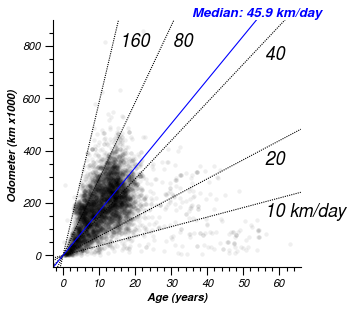

In [24]:
plt.figure(figsize=[4,4])
plt.plot(df.age/365.25,df.odometer/1000, markerfacecolor='k', markeredgecolor='none', linestyle='None', marker='o', ms=4 ,alpha=1/16)
plt.xlabel('Age (years)', style='italic')
plt.ylabel('Odometer (km x1000) ', style='italic')
xl = plt.xlim()
yl = plt.ylim()
xx = np.array(xl)*365.25
for p_d in [10, 20,40,80, 160]:
    yy = xx * p_d
    plt.plot(xx/365.25,yy/1000,':k')

    if p_d < 50:
        x = 20000
        y = p_d*x    
    else:
        y = 850000
        x = y/p_d
    if p_d == 10:
        txt_pat = ' {} km/day'
    else:
        txt_pat = ' {}'
    plt.text(x/365.25, y/1000, txt_pat.format(p_d), va='top', fontsize=16)

p_d = median_usage
yy = xx * p_d
plt.plot(xx/365.25,yy/1000,'-b')
plt.text(900000/median_usage/365.25,900000/1000,'Median: {:.1f} km/day'.format(median_usage), ha='center', va='bottom', color='b', fontweight='bold')
plt.xlim(xl)
plt.ylim(yl)
plt.xticks(range(0,65,10))


# save
if OPBOD:
    file_name = '../results/usage-regression-opbod.png'
else:
    file_name = '../results/usage-regression.png'

if (SKIPSAVE==False): #and (not(os.path.isfile(file_name))):
    print(file_name)
    with plt.style.context('../assets/context-paper.mplstyle'):
        plt.savefig(file_name, bbox_inches='tight', transparent=True)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')


In [25]:
for k,df_ in df.groupby('fuel'):
    print(k)
    


benzine
benzine/elektriciteit
benzine/lpg
benzine/lpg/
benzine/lpg/115r gasinstallatie
benzine/lpg/g2 gasinstallatie
benzine/lpg/g3 gasinstallatie
cng
cng/benzine
cng/benzine/af-fabriek gasinstallatie
diesel
diesel/elektriciteit
elektriciteit
elektriciteit/benzine
lpg
lpg/
lpg/benzine/af-fabriek gasinstallatie
lpg/benzine/g2 gasinstallatie
lpg/benzine/g3 gasinstallatie
lpg/g2 gasinstallatie


../results/usage-regression-loglog.png


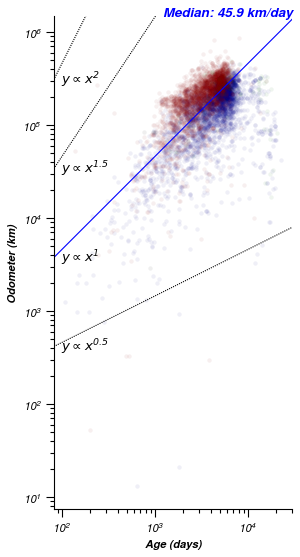

In [26]:
plt.figure(figsize=[8,8])
for k,df_ in df.groupby('fuel'):
    if 'lpg' in k:
        clr = 'darkgreen'
    elif 'benzine' in k:
        clr = 'darkblue'
    elif 'diesel' in k:
        clr = 'darkred'
    else:
        clr = 'k'
    plt.plot(df_.age,df_.odometer, markerfacecolor=clr, markeredgecolor='none', linestyle='None', marker='o', ms=4 ,alpha=1/16)
plt.xlabel('Age (days)', style='italic')
plt.ylabel('Odometer (km)', style='italic')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_aspect('equal')

xl = plt.xlim()
yl = plt.ylim()
p_d = median_usage
xx = np.array(xl)
yy = xx * p_d
plt.plot(xx,yy,'-b')
plt.text(xx[1],xx[1] * p_d,'Median: {:.1f} km/day'.format(median_usage), ha='right', va='bottom', color='b', fontweight='bold')
for angle,offset in zip([0.5, 1, 1.5, 2], [1,1,1,1]):

    yy = xx ** angle * median_usage * offset

    # label
    plt.text(xx[0],xx[0] ** angle * median_usage * offset,
             '  $y \propto x^{{{:g}}}$  '.format(angle,median_usage), ha='left', va='center',
             color='k')
    
    if angle == 1:
        continue
    # line
    plt.plot(xx,yy,':',color='k')


plt.xlim(xl)
plt.ylim(yl)

# save
if OPBOD:
    file_name = '../results/usage-regression-loglog-opbod.png'
else:
    file_name = '../results/usage-regression-loglog.png'

if (SKIPSAVE==False): #and (not(os.path.isfile(file_name))):
    print(file_name)
    with plt.style.context('../assets/context-paper.mplstyle'):
        plt.savefig(file_name, bbox_inches='tight', transparent=True)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')

../results/usage-dist.png


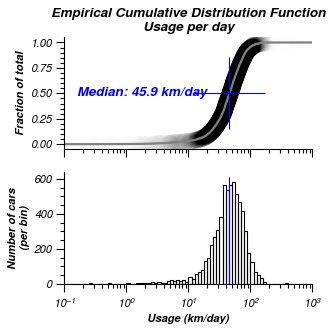

In [27]:
data = usage
x,y = ecdf(data)

# plot full
fig,axs=plt.subplots(figsize=[4,4], nrows=2, ncols=1, sharex=True)

axs[0].step(x, y, markerfacecolor='k', markeredgecolor='none', marker='o', alpha=0.005, ms=16)
axs[0].step(x, y, color='grey', linestyle='-', linewidth=2)
axs[0].plot(median_usage, 0.5, marker='+', markeredgecolor='b', ms=64)
axs[0].text(median_usage,0.5,'Median: {:.1f} km/day      '.format(median_usage), ha='right', va='center', color='b', weight='bold')

axs[1].hist(x, bins=np.logspace(-1,3,81), edgecolor='k', facecolor='None')
yl=axs[1].get_ylim()
axs[1].vlines(x=median_usage, ymin=0, ymax=yl[1], color='b')

axs[0].set_xscale('log')
axs[0].set_xlim(left=0.1, right=1000)
axs[0].set_title('Empirical Cumulative Distribution Function\nUsage per day', style='italic')
axs[0].set_yticks(np.linspace(0,1.0,5))
axs[1].set_xlabel('Usage (km/day)', style='italic')
axs[0].set_ylabel('Fraction of total', style='italic')
axs[1].set_ylabel('Number of cars\n(per bin)', style='italic')

# save
if OPBOD:
    file_name = '../results/usage-dist-opbod.png'
else:
    file_name = '../results/usage-dist.png'

if (SKIPSAVE==False): #and (not(os.path.isfile(file_name))):
    print(file_name)
    with plt.style.context('../assets/context-paper.mplstyle'):
        plt.savefig(file_name, bbox_inches='tight', transparent=True)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')
    

In [28]:
if VERBOSE > 0:
    # Reserve price?
    flat = []
    for e in [*yX.groupby([*map(lambda x: '-'.join(x.split('-')[0:2]), yX.index)]).price.apply(lambda x: [x.min()] * sum(x==x.min()))]:
        flat+=e
    df_=pd.Series(flat).value_counts().sort_index()
    # plt.plot(df_.index.astype(float), df_,'P:')
    df_